In [1]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2
import argparse
import os 
import os.path as osp
from og_model import Darknet
from og_utils import *
import pickle as pkl
import pandas as pd
import random
import matplotlib.pyplot as plt
from loss import Yolo_Loss

cfgfile = "cfg/og_model.cfg"
model = Darknet(cfgfile)
model.net_info["height"] = 416
inp_dim = int(model.net_info["height"])

grid_sizes=[13, 26, 52],                    # grid sizes for detection
anchors = np.array([                        # anchor box sizes per grid size
        [[116,90], [156,198], [373,326]],   
        [[30, 61], [62, 45], [59,119]],
        [[10, 13], [16, 30], [33, 23]],])

# Write Results

In [51]:
prediction = torch.load("ex_tensors/yolo_layer_output_size10647.pt")
confidence = 0.5 # filter grids without a pr(ob) > 0.5
num_classes = 80
nms_conf = 0.4

In [52]:
conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
prediction = prediction*conf_mask

In [53]:
box_corner = prediction.new(prediction.shape)
box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
prediction[:,:,:4] = box_corner[:,:,:4]

In [55]:
for ind in range(1):
    image_pred = prediction[ind]          #image Tensor
    #confidence threshholding 
    #NMS

    max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
    max_conf = max_conf.float().unsqueeze(1)
    max_conf_score = max_conf_score.float().unsqueeze(1)
    seq = (image_pred[:,:5], max_conf, max_conf_score)
    image_pred = torch.cat(seq, 1)
    
    non_zero_ind =  (torch.nonzero(image_pred[:,4]))
    try:
        image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
    except:
        continue
    
    if image_pred_.shape[0] == 0:
        continue     

In [65]:
image_pred.shape

torch.Size([10647, 7])

In [62]:
image_pred_ = torch.cat((torch.zeros((image_pred_.shape[0], 1)), image_pred_), 1)

In [63]:
image_pred_

tensor([[  0.0000, 260.4430,  96.7705, 370.6997, 145.4609,   0.9891,   0.8380,
           7.0000],
        [  0.0000, 268.3782,  94.7033, 374.9456, 145.8965,   0.7709,   0.8236,
           7.0000],
        [  0.0000,  59.0262, 109.7473, 309.9195, 266.9929,   0.7363,   0.9938,
           1.0000],
        [  0.0000,  91.1993, 100.4477, 304.9465, 276.3017,   0.5328,   0.9873,
           1.0000],
        [  0.0000,  63.6384, 119.8179, 309.9497, 289.3002,   0.9904,   0.9980,
           1.0000],
        [  0.0000,  87.8459, 116.1371, 307.0424, 289.9205,   0.9936,   0.9993,
           1.0000],
        [  0.0000,  71.3474, 173.7214, 168.3941, 327.2916,   0.9487,   0.9987,
          16.0000],
        [  0.0000,  67.1713, 162.9582, 173.7498, 338.0852,   0.9998,   0.9992,
          16.0000],
        [  0.0000,  71.9760, 157.9328, 192.1129, 335.5837,   0.8839,   0.9954,
          16.0000],
        [  0.0000,  69.0054, 183.4312, 167.7904, 336.2758,   0.9358,   0.9983,
          16.0000],
        [ 

In [36]:
write_results(prediction_raw, confidence, num_classes, nms_conf)

tensor([[  0.0000,  87.8459, 116.1371, 307.0424, 289.9205,   0.9936,   0.9993,
           1.0000],
        [  0.0000, 260.4430,  96.7705, 370.6997, 145.4609,   0.9891,   0.8380,
           7.0000],
        [  0.0000,  67.1713, 162.9582, 173.7498, 338.0852,   0.9998,   0.9992,
          16.0000]])

# Images into Detect Loop

In [2]:
images = "images"
imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]

In [3]:
imlist

['/home/mcav/panoptic_perception_network/images/dog-cycle-car.png',
 '/home/mcav/panoptic_perception_network/images/0001542f-7c670be8.jpg',
 '/home/mcav/panoptic_perception_network/images/0000f77c-62c2a288.jpg',
 '/home/mcav/panoptic_perception_network/images/0000f77c-6257be58.jpg',
 '/home/mcav/panoptic_perception_network/images/0001542f-5ce3cf52.jpg']

In [11]:
loaded_ims = [cv2.imread(x) for x in imlist]
for im in loaded_ims:
    print(im.shape)

(452, 602, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


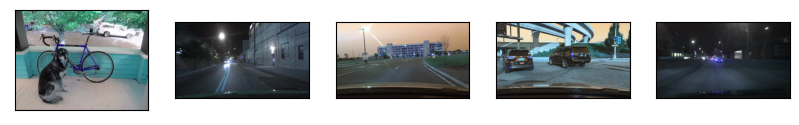

In [22]:
fig, axs = plt.subplots(1, len(loaded_ims))
for i, ax in enumerate(axs):
    ax.imshow(loaded_ims[i])

    ax.set_xticks([])
    ax.set_yticks([])

plt.gcf().set_size_inches(10,20)

In [16]:
im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
for im in im_batches:
    print(im.shape)

torch.Size([1, 3, 416, 416])
torch.Size([1, 3, 416, 416])
torch.Size([1, 3, 416, 416])
torch.Size([1, 3, 416, 416])
torch.Size([1, 3, 416, 416])


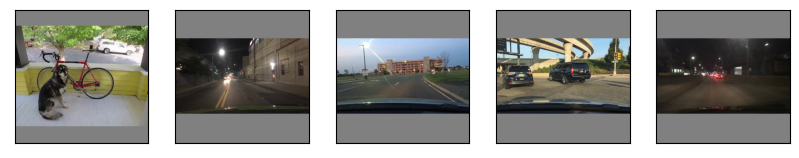

In [24]:
fig, axs = plt.subplots(1, len(im_batches))
for i, ax in enumerate(axs):
    ax.imshow(im_batches[i][0].permute(1,2,0))

    ax.set_xticks([])
    ax.set_yticks([])

plt.gcf().set_size_inches(10,20)

# Images from Dataset

In [7]:
from dataset import *
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [8]:
rgb_mean = [92, 103, 105]
rgb_std  = [66, 71, 75]
bs = 5
label_dict = "debug_dataset/labels/det_train_shortened.json" 
root_dir = "debug_dataset/images"   # labels json

### Without Norm

In [9]:
train_data = DetectionDataset(
    label_dict,
    root_dir,
    "data/bdd100k.names",
    grid_sizes=[13, 26, 52],                    # grid sizes for detection
    anchors = np.array([                        # anchor box sizes per grid size
            [[116,90], [156,198], [373,326]],   
            [[30, 61], [62, 45], [59,119]],
            [[10, 13], [16, 30], [33, 23]],
    ]),
    transform=transforms.Compose([              # transforms
        # Normalise(                              # 1. normalise
        #     mean=rgb_mean,                      
        #     std=rgb_std
        # ),
        Pad(416),                               # 2. padding
        ToTensor()                              # 3. convert to tensor
    ])
)

loader = DataLoader(
    train_data,
    batch_size=bs,
    shuffle=False,
    num_workers=8,
)

In [10]:
images_, labels_ = next(iter(loader)).values()

### With Norm

In [6]:
transformed_train_data = DetectionDataset(
    label_dict=label_dict,                      # labels corresponding to images
    root_dir=root_dir,                          # images root dir
    classes_file="data/bdd100k.names",          # class names
    grid_sizes=[13, 26, 52],                    # grid sizes for detection
    anchors = np.array([                        # anchor box sizes per grid size
            [[116,90], [156,198], [373,326]],   
            [[30, 61], [62, 45], [59,119]],
            [[10, 13], [16, 30], [33, 23]],
        ]),
    transform=transforms.Compose([              # transforms
        Normalise(                              # 1. normalise
            mean=rgb_mean,                      
            std=rgb_std
        ),
        Pad(416),                               # 2. padding
        ToTensor()                              # 3. convert to tensor
    ])
)

# separate transformed dataset into batches
train_loader = DataLoader(
    transformed_train_data,
    batch_size=bs,
    shuffle=False,
    num_workers=8,
)

In [7]:
images, labels = next(iter(train_loader)).values()

### Show Images

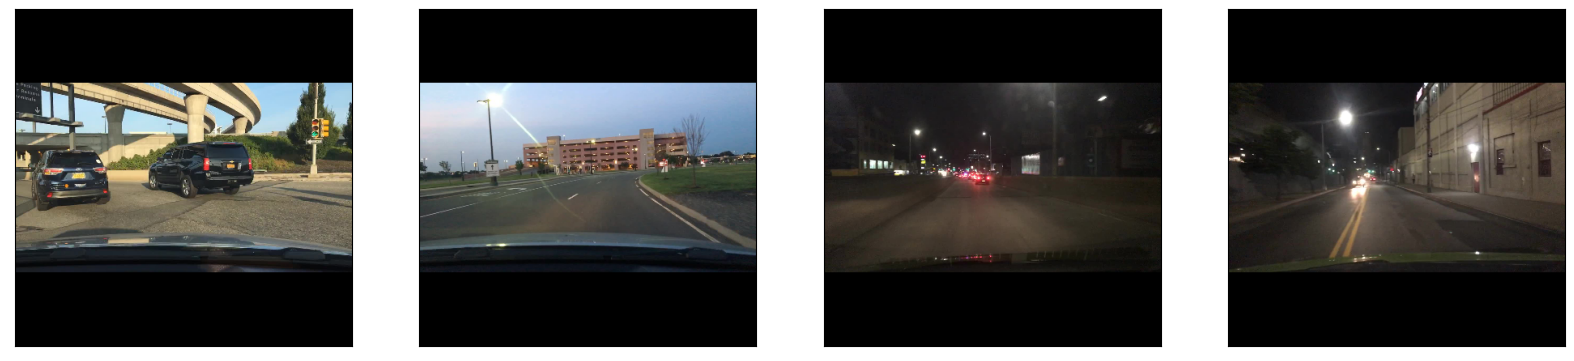

In [11]:
fig, axs = plt.subplots(1,images_.shape[0])

for i, ax in enumerate(axs):
    ax.imshow(images_[i].type(torch.int32).permute(1,2,0))
    ax.set_xticks([])
    ax.set_yticks([])

plt.gcf().set_size_inches(20,10)

In [22]:
labels_[0,:507].shape

torch.Size([507, 17])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


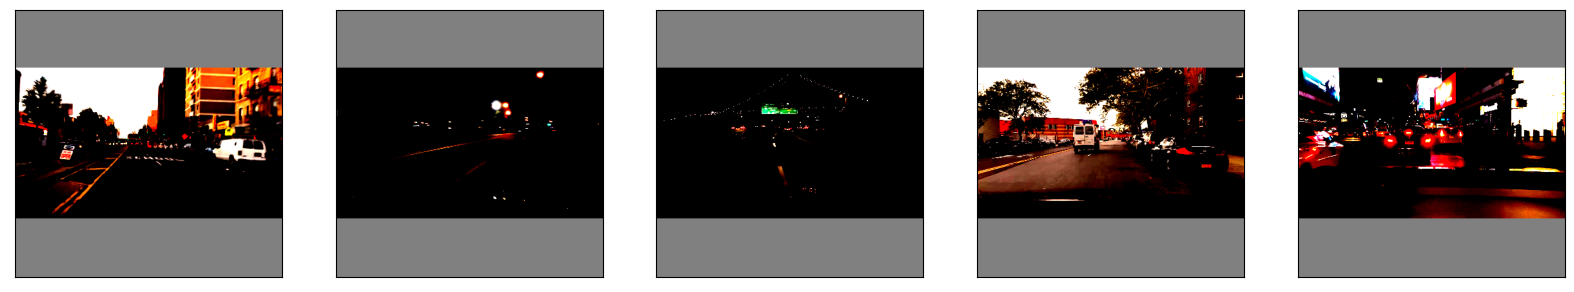

In [9]:
fig, axs = plt.subplots(1,images.shape[0])

for i, ax in enumerate(axs):
    ax.imshow(images[i].permute(1,2,0))
    ax.set_xticks([])
    ax.set_yticks([])

plt.gcf().set_size_inches(20,10)

In [14]:
def draw_labels(images, labels, anchors=None):
    if len(images.shape) == 3: # for batch size = 1
        fig, ax = plt.subplots(1, 1)
        cur_labels = labels
        label_bboxes = cur_labels[cur_labels.sum(dim=1) != 0][...,:4]

        # convert bbox labels to corners
        box_corner = label_bboxes.new(label_bboxes.shape)
        box_corner[...,0] = (label_bboxes[...,0] - label_bboxes[...,2]/2) # x_c - w/2 = x_min
        box_corner[...,1] = (label_bboxes[...,1] - label_bboxes[...,3]/2) # y_c - h/2 = y_min
        box_corner[...,2] = (label_bboxes[...,0] + label_bboxes[...,2]/2) # x_c + w/2 = x_max
        box_corner[...,3] = (label_bboxes[...,1] + label_bboxes[...,3]/2) # y_c + h/2 = y_max

        if images[0].max()>15: # sketchy way to check if its normalised or not
            ax.imshow(images.type(torch.int32).permute(1,2,0))
        else:
            ax.imshow(images.permute(1,2,0))
        
        for box in box_corner:
            x_points = [box[0], box[0], box[2], box[2], box[0]]
            y_points = [box[1], box[3], box[3], box[1], box[1]]
            
            ax.plot(x_points, y_points, 'r-', linewidth=0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Labels: {box_corner.shape[0]}  ||  Objects: {box_corner.unique(dim=0).shape[0]}")
    
    else: # for batch size > 1
        fig, axs = plt.subplots(1, images.shape[0])
        for i, ax in enumerate(axs):
            cur_labels = labels[i]
            label_bboxes = cur_labels[cur_labels.sum(dim=1) != 0][...,:4]
            
            # convert bbox labels to corners
            box_corner = label_bboxes.new(label_bboxes.shape)
            box_corner[...,0] = (label_bboxes[...,0] - label_bboxes[...,2]/2) # x_c - w/2 = x_min
            box_corner[...,1] = (label_bboxes[...,1] - label_bboxes[...,3]/2) # y_c - h/2 = y_min
            box_corner[...,2] = (label_bboxes[...,0] + label_bboxes[...,2]/2) # x_c + w/2 = x_max
            box_corner[...,3] = (label_bboxes[...,1] + label_bboxes[...,3]/2) # y_c + h/2 = y_max

            # convert anchor labels to corners
            #anchors = anchors.reshape(-1,2)

            if images[0].max()>15: # sketchy way to check if its normalised or not
                ax.imshow(images[i].type(torch.int32).permute(1,2,0))
            else:
                ax.imshow(images[i].permute(1,2,0))
            
            for box in box_corner:
                # show bounding boxes
                x_points = [box[0], box[0], box[2], box[2], box[0]]
                y_points = [box[1], box[3], box[3], box[1], box[1]]
                
                ax.plot(x_points, y_points, 'r-', linewidth=0.5)

                # show anchors boxes

                
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Labels: {box_corner.shape[0]}  ||  Objects: {box_corner.unique(dim=0).shape[0]}")

    plt.gcf().set_size_inches(20,10)

In [33]:
anchors

array([[[116,  90],
        [156, 198],
        [373, 326]],

       [[ 30,  61],
        [ 62,  45],
        [ 59, 119]],

       [[ 10,  13],
        [ 16,  30],
        [ 33,  23]]])

In [34]:
anchors.reshape(-1,2)[0]

array([116,  90])

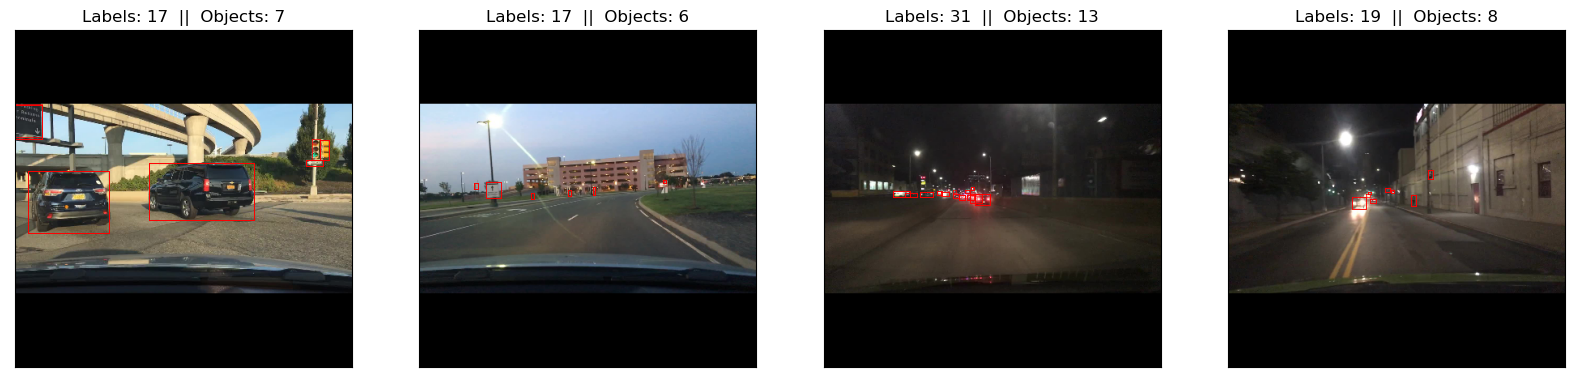

In [15]:
draw_labels(images_, labels_)

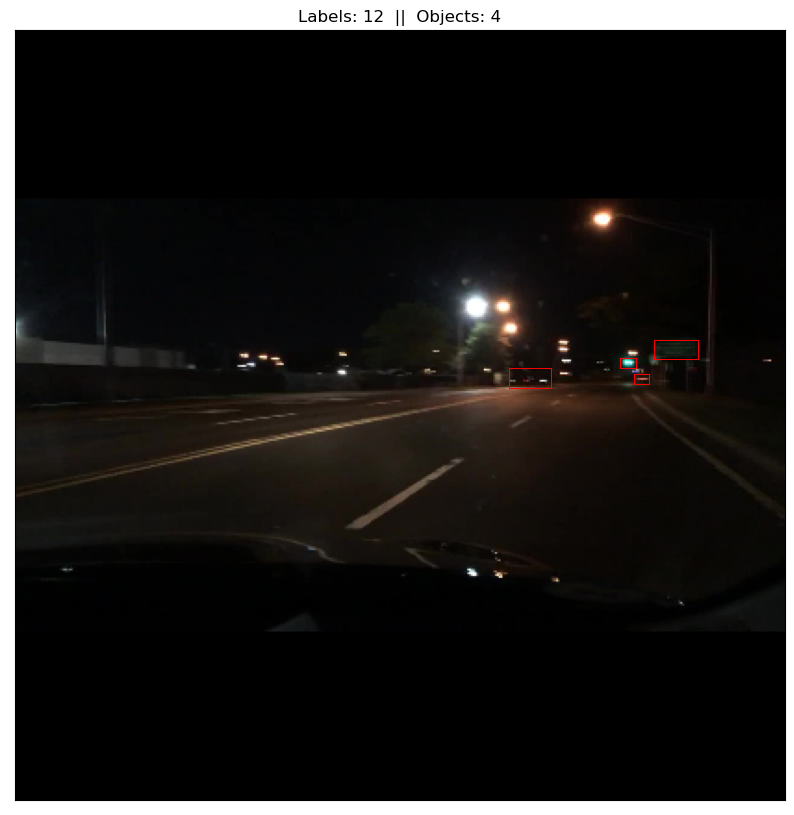

In [27]:
draw_labels(images_[1], labels_[1])

In [241]:
def distort_label(label, deltas):
    dx, dy, dw, dh = deltas

    cur_bboxes = label[...,:4]
    obj_mask = (cur_bboxes.sum(dim=1) != 0).unsqueeze(1)

    t_mat = cur_bboxes.new(cur_bboxes.shape)

    t_mat[...,0] = dx
    t_mat[...,1] = dy
    t_mat[...,2] = dw
    t_mat[...,3] = dh
    t_mat = t_mat*obj_mask

    transformed_bboxes = label[...,:4] + t_mat
    transformed_label = label.clone()
    transformed_label[...,:4] = transformed_bboxes

    return transformed_label

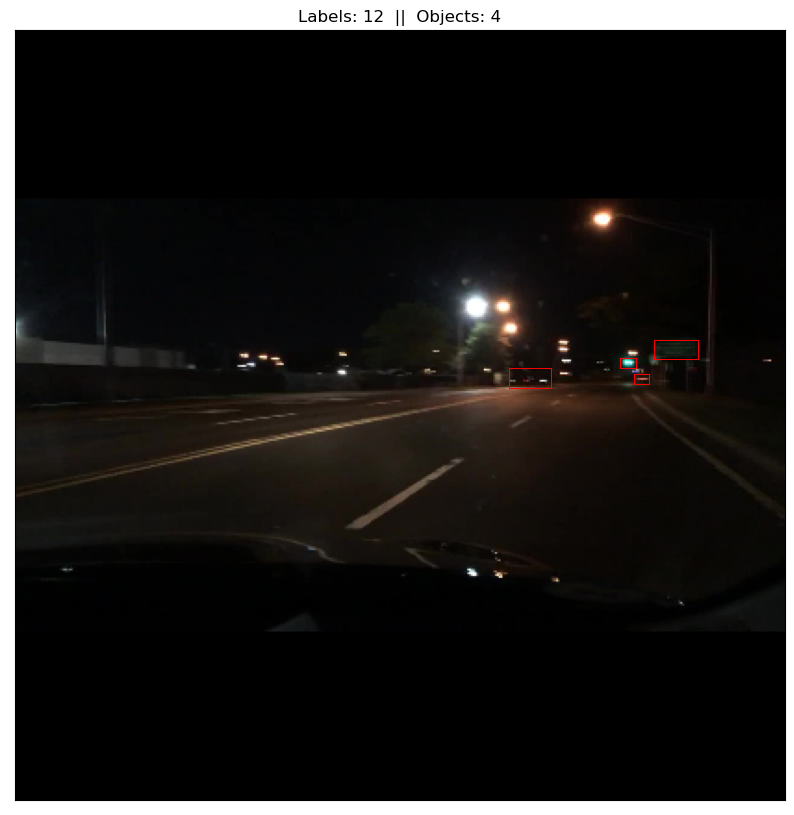

In [242]:
x_shift = distort_label(labels_[1], [0, 0, 0, 0])
draw_labels(images_[1], x_shift)

# Loss

In [16]:
criterion = Yolo_Loss()

In [244]:
dist = distort_label(labels_[1], [10, 0, 0, 0])
criterion(labels_[1], dist)

(tensor(1.6568, device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0.0381, device='cuda:0'),
 tensor(1.6187, device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(40.5494, device='cuda:0'))

In [247]:
dist = distort_label(labels_[1], [0, 0, 20, 0])
criterion(labels_[1], dist)

(tensor(3.8873, device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(2.2686, device='cuda:0'),
 tensor(1.6187, device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(54.1719, device='cuda:0'))